In [101]:
import random
import numpy as np
import cec2017.functions as functions
import copy

In [102]:
Dim = 50
NP = 10
bound = 100

In [103]:
X = np.random.uniform(low=-bound, high=bound, size=Dim)
X_min = X.min()
X_max = X.max()
X_list = np.empty([NP, Dim])
for i in range(NP):
    for j in range(Dim):
        X_list[i][j] = X_min + random.uniform(0, 1) * (X_max - X_min)

X_list

array([[-5.56786386e+01,  3.25568896e+01,  6.81740003e+01,
        -4.09473711e+01,  5.37531080e+01,  3.42448320e+01,
         3.82539399e+01, -5.37722659e+01,  6.94841093e+01,
         1.29998909e+01, -8.84509123e+01, -7.44961244e+01,
         3.59442992e+01, -8.68303519e+01,  4.69850222e+01,
        -4.91986163e+01, -2.28377350e+01,  7.91061107e+01,
         3.18889298e+01,  7.42161135e+01,  6.56870159e+01,
         4.64613940e+01, -2.93586826e+01, -5.07948769e+01,
         1.81629319e+01,  9.46666846e+01,  4.64747143e+01,
         5.24495359e+01, -5.05655833e+01,  7.86990925e+01,
        -1.88600445e+01,  9.49122409e+01,  2.03787872e+01,
        -3.71247344e+01,  5.73513704e+01,  5.75307026e+01,
        -5.18950570e+01, -7.16766475e+01, -4.71382558e+01,
         8.20186927e+01, -6.94858501e+01, -2.12229744e+00,
        -1.12091797e+01,  5.71222890e+01, -1.73179639e+01,
        -7.65394787e+01,  4.63283831e+01, -1.84948838e+01,
        -7.26327824e+01,  8.00803281e+01],
       [-7.54

In [104]:
""":parameter for DE"""
T_DE = 100
no = 5
CR = 0.9  # rate of crossover

""":parameter for MMS"""
mms_e = 0.000001
mms_F = 0.5

In [105]:
""":parameter k and F: for current/rand/1"""
k = 0.3
F = 0.5

In [106]:
""":parameter for crossoverSBX"""
sbx_n = 10

In [107]:
# f = functions.f1

In [108]:
def feas(x):
    if x.max() <= bound and x.min() >= -bound:
        return 1
    else:
        return 0

In [109]:
def select_better_fit(x1, x2, f):
    if f(x1) <= f(x2):
        return x1
    else:
        return x2

In [110]:
def current_to_rand(x_list, r1, r2, r3, i):
    return np.add(x_list[i], k * np.subtract(x_list[r1], x_list[i]), F * np.subtract(x_list[r2], x_list[r3]))

In [111]:
def immsade(xx_list, r1, r2, r3):
    immsade_omega = random.uniform(0.7, 1.0)
    immsade_F = random.uniform(0.5, 0.8)
    v_delta = np.add(np.multiply(immsade_omega, xx_list[r1]),
                     immsade_F * np.subtract(xx_list[r2], xx_list[r3]))
    v_delta = np.maximum(v_delta, -100)
    v_delta = np.minimum(v_delta, 100)
    return v_delta

In [112]:
def crossover_SBX(x_i, v_j, f):
    beta = 0
    while isinstance(beta, complex):
        sbx_rand = random.random()
        if sbx_rand <= 0.5:
            beta = (2 * sbx_rand) ** (1 / (1 + sbx_n))
        else:
            beta = (1 / (2 - sbx_n * 2)) ** (1 / (1 + sbx_n))

    c1 = 0.5 * np.add((1 + beta) * x_i, (1 - beta) * v_j)  # crossover
    c2 = 0.5 * np.add((1 - beta) * x_i, (1 + beta) * v_j)
    return select_better_fit(c1, c2, f)

In [113]:
def DE(f):
    x_list = copy.deepcopy(X_list)
    x_best = x_list[0]
    # print(x_list[0])

    t = 1
    while t <= T_DE:
        for i in range(NP):
            u_best = np.empty([Dim])
            for j in range(Dim):
                r_list = random.sample(range(NP), 5)
                for m in range(no):
                    while r_list[m] == i:
                        r_list[m] = random.randint(0, NP - 1)

                v_j = np.empty([Dim])
                v_j = immsade(x_list, r_list[1], r_list[2], r_list[3])

                cr_rand = random.random()
                if cr_rand <= CR:
                    u_j = crossover_SBX(x_list[i], v_j, f)
                else:
                    u_j = x_list[i]

                if j == 0:
                    u_best = u_j
                else:
                    u_best = select_better_fit(u_best, u_j, f)

                if f(u_best) <= f(x_list[i]) and feas(u_best) == 1:
                    x_list[i] = u_best

                if f(x_list[i]) < f(x_best) and feas(x_list[i]) == 1:
                    x_best = x_list[i]

        t += 1
    return x_best


In [114]:
""":parameter: for AGDE"""
T_AGDE = 100

In [115]:
def index_of_X_best(xx_list, f):
    index = 0
    min_fit = f(xx_list[0])
    for i in range(len(xx_list)):
        if f(xx_list[i]) < min_fit:
            index = i
            min_fit = f(xx_list[i])
    return index


def index_of_X_worst(xx_list, f):
    index = 0
    max_fit = f(xx_list[0])
    for i in range(len(xx_list)):
        if f(xx_list[i]) > max_fit:
            index = i
            max_fit = f(xx_list[i])
    return index


def compare_max(delta):
    """
    lower bound
    :param delta: delta
    :return: turn into lower bound delta
    """

    em = np.linspace(-100, -100, Dim)
    delta = np.maximum(delta, em)
    return delta


def compare_min(delta):
    on = np.linspace(100, 100, Dim)
    delta = np.minimum(delta, on)
    # for i in range(len(delta)):
    #     delta[i] = min(delta[i], 1)
    return delta

def agde(xx_list, agde_F, agde_p, f):
    agde_NP = max(int(NP * agde_p), 0)
    r_list = random.randint(max(agde_NP * 2 - 1, 0), NP - 1)
    if max(agde_NP, 0) >= max(agde_NP * 2 - 1, 1):
        m = max(agde_NP, 0) + 1
    else:
        m = max(agde_NP * 2 - 1, 1)
    x_p_worst = xx_list[index_of_X_worst(xx_list[max(agde_NP, 0): m], f)]
    x_p_best = xx_list[index_of_X_best(xx_list[: max(agde_NP - 1, 1)], f)]
    v_delta = np.add(xx_list[r_list], np.multiply(agde_F, np.subtract(x_p_best, x_p_worst)))
    return v_delta

In [116]:
def AGDE(f):
    xx_list = copy.deepcopy(X_list)
    x_best = xx_list[0]
    # print(xx_list[0])

    G = 0
    p_j = 0.5
    s_j_sum = 0
    while G <= T_AGDE:  # iteration of DE
        n_s_j = 0
        f_j = 1
        for i in range(NP):  # iteration of generation
            agde_F = random.uniform(0.1, 1)
            Cr = 0
            if G == 1:
                if random.uniform(0, 1) <= 0.5:
                    Cr = random.uniform(0.05, 0.15)
                else:
                    Cr = random.uniform(0.9, 1)
            else:
                if random.uniform(0, 1) <= p_j:
                    Cr = random.uniform(0.05, 0.15)
                else:
                    Cr = random.uniform(0.9, 1)
            j_random = random.randint(1, NP)

            u_best = np.empty([Dim])
            for j in range(Dim):
                vj = agde(xx_list, agde_F, p_j, f)
                vj = compare_max(vj)
                vj = compare_min(vj)
                if random.uniform(0, 1) < Cr or j == j_random:
                    u_j = crossover_SBX(xx_list[i], vj, f)
                else:
                    u_j = xx_list[i]

                if j == 0:
                    u_best = u_j
                else:
                    u_best = select_better_fit(u_best, u_j, f)

                if f(u_best) <= f(xx_list[i]) and feas(u_best) == 1:
                    xx_list[i] = u_best

                if f(xx_list[i]) < f(x_best) and feas(xx_list[i]) == 1:
                    x_best = xx_list[i]

        G += 1

        s_j = n_s_j / (n_s_j + f_j) + 0.01
        s_j_sum += s_j
        p_s_j = s_j / s_j_sum
        if (((G - 1) * p_j + p_s_j) / G) < 0.5:
            p_j = ((G - 1) * p_j + p_s_j) / G

    return x_best

In [117]:
""":parameter: for GSK"""
T_GSK = 100
GSK_p = 0.1
k_f = 0.01   # 0.5
k_r = 0.1   # 0.9
K = 10

In [118]:
def junior(xx_list, r, i, f):
    if random.uniform(0, 1) <= k_r:
        if f(xx_list[i]) > f(xx_list[r]):
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(xx_list[max(0, i - 1)], xx_list[min(NP - 1, i + 1)]),
                                          np.subtract(xx_list[r], xx_list[i])))
        else:
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(xx_list[max(0, i - 1)], xx_list[min(NP - 1, i + 1)]),
                                          np.subtract(xx_list[i], xx_list[r])))
    else:
        v_delta = xx_list[i]
    return v_delta


def senior(xx_list, i, D_junior, f):
    if random.uniform(0, 1) <= k_r:
        D_senior = NP - D_junior
        NP_1 = int(D_senior * GSK_p)
        r_list = random.randint(D_junior - 1 + NP_1 * 2, NP - 1)
        if max(D_junior - 1 + NP_1, 0) >= max(D_junior - 1 + NP_1 * 2 - 1, 1):
            m = max(D_junior - 1 + NP_1, 0) + 1
        else:
            m = max(D_junior - 1 + NP_1 * 2 - 1, 1)
        if max(D_junior - 1, 0) >= max(D_junior - 1 + NP_1 - 1, 1):
            n = max(D_junior - 1, 0) + 1
        else:
            n = max(D_junior - 1 + NP_1 - 1, 1)
        x_p_worst = xx_list[index_of_X_worst(xx_list[max(D_junior - 1 + NP_1, 0): m], f)]
        x_p_best = xx_list[index_of_X_best(xx_list[max(D_junior - 1, 0): n], f)]
        if f(xx_list[i]) > f(xx_list[r_list]):
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(x_p_best, x_p_worst),
                                          np.subtract(xx_list[r_list], xx_list[i])))
        else:
            v_delta = np.add(xx_list[i],
                             k_f * np.add(np.subtract(x_p_best, x_p_worst),
                                          np.subtract(xx_list[i], xx_list[r_list])))
    else:
        v_delta = xx_list[i]
    return v_delta


In [119]:
def GSK(f):
    """
    DE algorithm
    :param x_list:
    :return: best x by DE
    """
    xxx_list = copy.deepcopy(X_list)

    x_best = xxx_list[0]
    # print(xxx_list[0])
    G = 0

    while G <= T_GSK:  # iteration of DE
        D_junior = int(NP * pow((1 - G / T_GSK), K))

        for i in range(NP):  # iteration of generation

            u_best = np.empty([Dim])
            for j in range(NP):
                vj = np.empty([Dim])
                r = random.randint(0, NP - 1)
                if j <= D_junior:
                    vj = junior(xxx_list, r, j, f)
                else:
                    vj = senior(xxx_list, j, D_junior, f)

                vj = compare_max(vj)
                vj = compare_min(vj)

                if j == 0:
                    u_best = vj
                else:
                    u_best = select_better_fit(u_best, vj, f)

                if f(u_best) <= f(xxx_list[i]) and feas(u_best) == 1:
                    xxx_list[i] = u_best

                if f(xxx_list[i]) < f(x_best) and feas(xxx_list[i]) == 1:
                    x_best = xxx_list[i]

        G += 1

    return x_best


In [120]:
import os
test_list = np.empty([len(functions.all_functions), 3])
test_path = r'D:\profile\codes\python_projects\ocp\test\output\D50'
for i in range(1, 52):
    j = 0
    for f in functions.all_functions:
        x_best_DE_fit = 0
        x_best_AGDE_fit = 0
        x_best_GSK_fit = 0
        x_best_DE_fit = f(DE(f))
        x_best_AGDE_fit = f(AGDE(f))
        x_best_GSK_fit = f(GSK(f))
        print(f.__name__, x_best_DE_fit, x_best_AGDE_fit, x_best_GSK_fit, "\n")
        test_list[j][0] = x_best_DE_fit
        test_list[j][1] = x_best_AGDE_fit
        test_list[j][2] = x_best_GSK_fit
        j += 1

    np.savetxt(os.path.join(test_path, str(i) + ".txt"), test_list)




f1 1093159526719.1152 1583596698835.744 2660666092955.1562 

f2 1.1247382624579831e+79 2.7772558499388905e+88 8.361994118808577e+94 

f3 249761.46339634154 489740.0926357279 1969013417679.4443 

f4 48690.208195240135 84089.70390923224 130416.72488649808 

f5 1186.7453822953503 1337.070960552473 1789.8686266361556 

f6 735.1936324889756 786.8253430243142 803.0916023685531 

f7 1875.9967024920936 3650.06403351296 6870.675506694605 

f8 1484.5262389257746 1614.0890539074708 1930.7200377571241 

f9 32622.394172993452 63039.85556427312 95827.46605064973 

f10 14835.010691025807 16020.69443344553 19256.644969285488 

f11 31944.69551610336 49881.49615337442 91807.71420772836 

f12 977876055347.354 1256819005574.937 1852360688151.447 

f13 433078046631.184 811635858955.8854 1230011599168.4502 

f14 203185034.48354733 750218283.7335877 2259633625.7112336 

f15 22519826638.457523 137315639906.36707 601009898600.3069 

f16 8731.007245079822 9269.218165824808 15262.36378162444 



c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\basic.py:227: RuntimeWarning: invalid value encountered in true_divide
  t = np.abs(tjx - np.round(tjx)) / tj


f17 nan nan nan 

f18 291377374.48415446 802240495.0592917 2797942328.9214516 

f19 24801320823.121746 40644619126.5458 161027237765.27356 

f20 nan nan nan 

f21 3284.8244167131934 3616.2024714755717 3770.346609606466 

f22 16866.770836118925 19888.041021187666 21046.709988675346 

f23 5299.695141383692 6261.914325300635 6887.891754913967 

f24 5323.120325081071 7134.090035985362 7080.92058752456 

f25 12543.816259327332 38123.79874127333 60500.99039980849 

f26 18349.256557513156 27391.792225240275 44020.47642553599 

f27 6432.074299705518 10142.818072918853 10504.473279360958 

f28 10230.152394358764 22143.490046018913 35508.50327504491 

f29 nan nan nan 

f30 65838998366.10247 102851026852.226 164637659036.326 

f1 1099257744897.348 1694824174169.8408 2660666092955.1562 

f2 2.8537700397396494e+76 6.626801617501932e+87 1.066826975714962e+95 

f3 257315.62560168427 48534014380.72296 2794998885197.4067 

f4 49643.68370585274 108050.04982172592 130416.72488649808 

f5 1199.78767362798

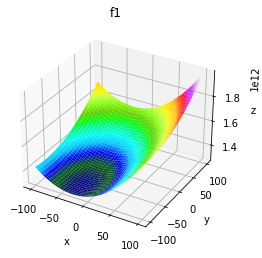

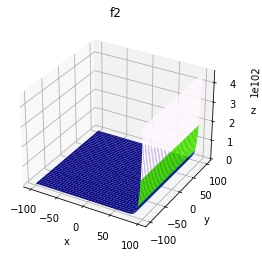

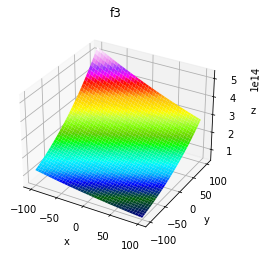

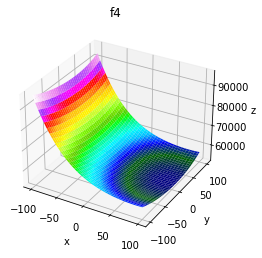

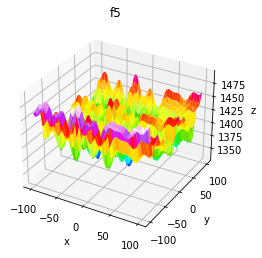

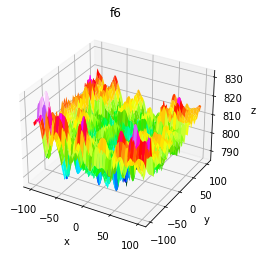

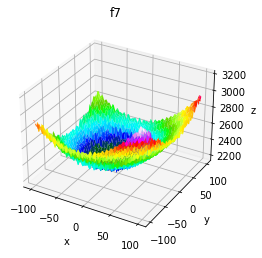

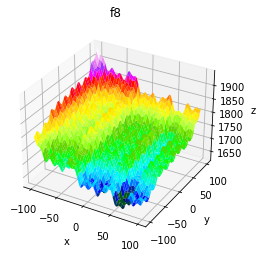

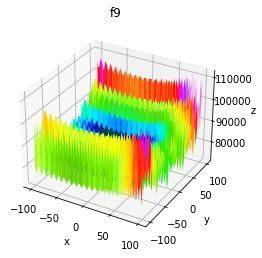

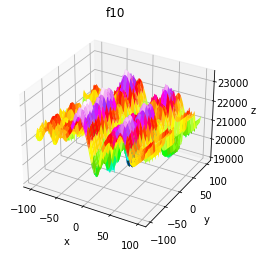

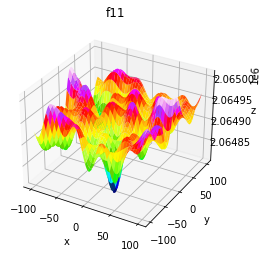

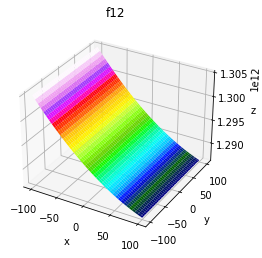

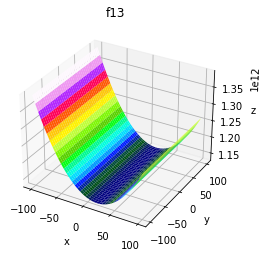

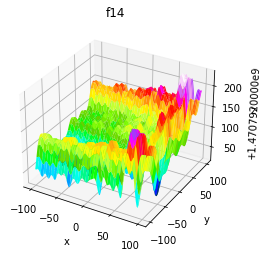

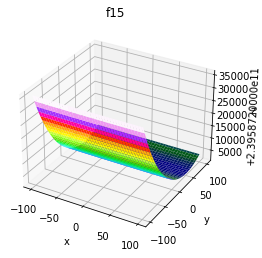

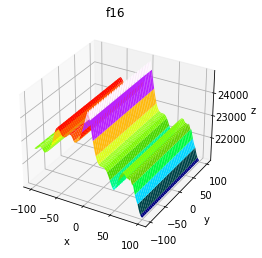

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\basic.py:227: RuntimeWarning: invalid value encountered in true_divide
  t = np.abs(tjx - np.round(tjx)) / tj
c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\cec2017\utils.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, Z, cmap='gist_ncar', edgecolor='none')


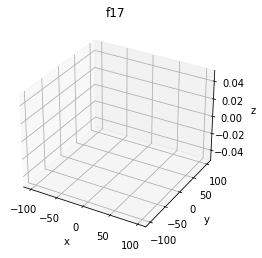

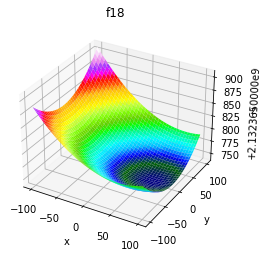

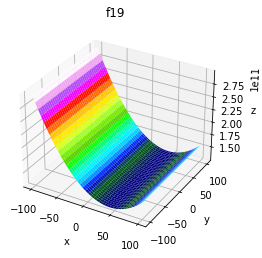

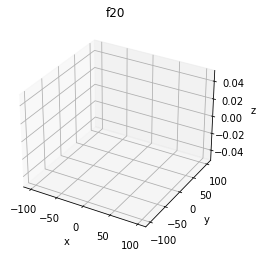

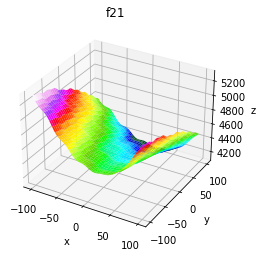

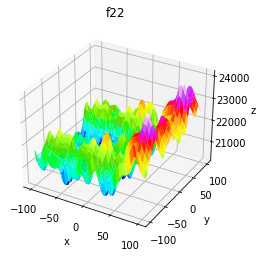

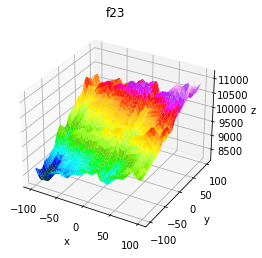

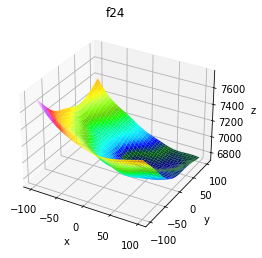

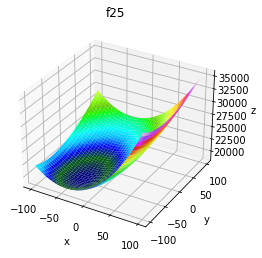

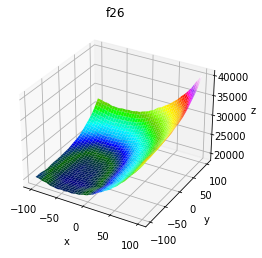

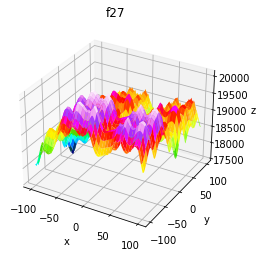

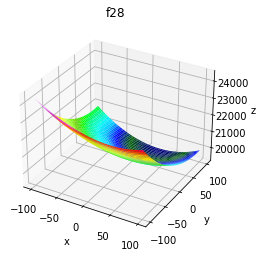

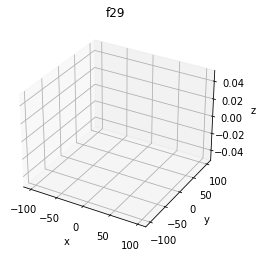

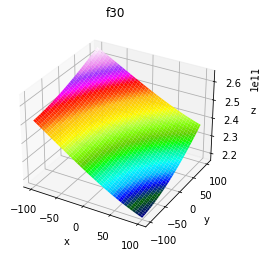

In [121]:
import cec2017.utils as utils
for f in functions.all_functions:
    utils.surface_plot(f, points=120, dimension=Dim)